## Filter Twitter data to add new tweets.

This notebook refers to a Google sheet with a list of tweets, and compares with a dump of tweets in json format to find which should be added.



In [1]:
import io
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
from IPython.display import display, HTML
from ReadTweetsFromJson import get_tweets_from_json_file

Details of the sheet used for annotating tweets.

In [2]:
KEY = '1qKYUxq_UrUFJy45r5KGuXp6gq-2ZF_VDb6-e7tWagwA'
SHEET_NAME = 'Analysis'

Helper functions for reading the existing tweets in the sheet, and filtering new ones that have not yet been included.

In [3]:
def get_already_processed(key: str, sheet_name: str) -> set:
    '''Returns the IDs of tweets that are already in the analysis.'''
    csv_url = (f'https://docs.google.com/spreadsheets/d/{key}'
               f'/gviz/tq?tqx=out:csv&sheet={sheet_name}')
    df = pd.read_csv(csv_url)
    already_processed = set(df['Tweet ID'])
    return already_processed

def is_interesting(tweet: dict) -> bool:
    '''Applies simple filtering criteria to a tweet.'''
    text = tweet.get('full_text') or tweet.get('text')
    if not text:
        return False
    is_retweet = 'retweeted_status' in tweet
    contains_url = len(tweet['entities']['urls']) > 0
    return not (is_retweet or contains_url)
    
def get_new_tweets(tweets, already_processed) -> pd.DataFrame:
    '''Returns the tweets which are interesting and not yet included.'''
    new_tweets = pd.DataFrame()
    for tweet in tweets:
        text = tweet.get('full_text') or tweet.get('text')
        if is_interesting(tweet) and tweet['id'] not in already_processed:
            new_tweets = new_tweets.append(
                {'text': text,
                 'id': str(tweet['id']),
                 'time': tweet['created_at']},
                ignore_index=True)
            already_processed.add(tweet['id'])
    new_tweets.id = new_tweets.id.astype('int64')
    return new_tweets
            
def get_excluded_tweets(tweets: List[dict]) -> pd.DataFrame:
    '''Returns all tweets that were excluded.'''
    excluded_tweets = pd.DataFrame()
    for tweet in tweets:
        if not is_interesting(tweet):
            excluded_tweets = excluded_tweets.append(
                {'text': tweet.get('full_text') or tweet.get('text'),
                 'id': str(tweet['id']),
                 'time': tweet['created_at']},
                ignore_index=True)  
    excluded_tweets.id = excluded_tweets.id.astype('int64')
    return excluded_tweets

Process a dump of tweets and save files with the new tweets to be added, and those which were discarded as not interesting.

In [4]:
JSON_PATH = 'mask_tweets_v3.json'

tweets = get_tweets_from_json_file(JSON_PATH)
already_processed = get_already_processed(KEY, SHEET_NAME)
new_tweets = get_new_tweets(tweets, already_processed)
excluded_tweets = get_excluded_tweets(tweets)

FileNotFoundError: [Errno 2] No such file or directory: 'mask_tweets_v3.json'

In [ ]:
new_tweets

In [ ]:
# Re-order columns to match order in spreadsheet
cols = ['id', 'time', 'text']
new_tweets = new_tweets[cols]
excluded_tweets = new_tweets[cols]

# Create csv files without the index column for easy merging with the spreadsheet 
new_tweets.to_csv('new.csv', index=False)
excluded_tweets.to_csv('excluded.csv', index=False)

## Analysis

Get the breakdown of messages per category, and sample messages.

In [5]:
sheet_name = 'Combined'
csv_url = (f'https://docs.google.com/spreadsheets/d/{KEY}'
           f'/gviz/tq?tqx=out:csv&sheet={sheet_name}')
df = pd.read_csv(csv_url)

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


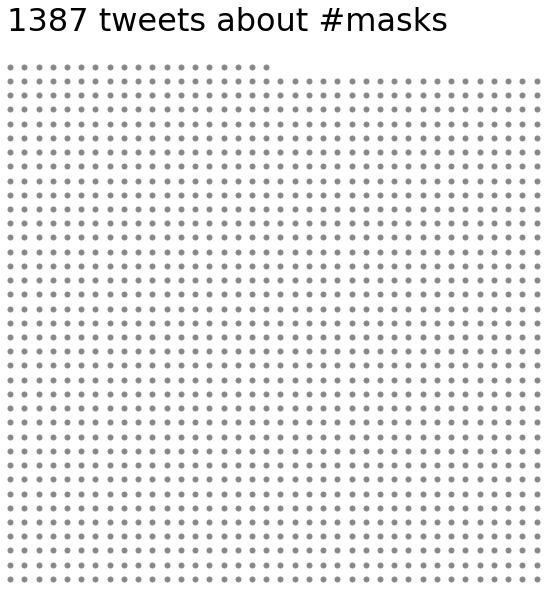

In [6]:
sunbird_orange = '#dc7828'
sunbird_red = '#f03232'
sunbird_font = {'fontname':'Roboto'}
square_size = int(np.sqrt(len(df))) + 1

for y in range(square_size):
    for x in range(square_size):
        index = (y * square_size) + x + 1
        if index > len(df):
            color = 'w'
        else:
            color = '#888888'
        plt.plot(x, y,
                 markersize=5,
                 marker='o',
                 color=color,
                 markeredgecolor=None) 

plt.axis('square')
plt.axis('off')
plt.xlim(-.2, square_size)
plt.ylim(-.2, square_size)
plt.gcf().set_size_inches(10, 10)
plt.title(f'{len(df)} tweets about #masks',
          loc='left', fontsize=32, **sunbird_font)
plt.savefig(f'images/all.png', dpi=150, bbox_inches='tight')

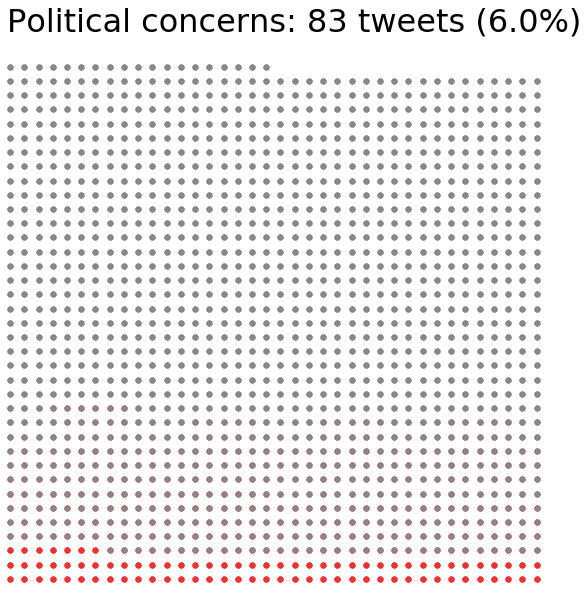

In [8]:
for tag in ['Use of Masks', 'Implementation', 'Political concerns']:
    
    tag_count = np.sum(df[tag])
    tag_proportion = tag_count / len(df)

    for y in range(square_size):
        for x in range(square_size):
            index = (y * square_size) + x + 1
            if index > len(df):
                color = 'w'
            elif index > tag_count:
                color = '#888888'
            else:
                color = sunbird_red            
            plt.plot(x, y,
                     markersize=5,
                     marker='o',
                     color=color,
                     markeredgecolor=None) 

    plt.axis('square')
    plt.axis('off')
    plt.xlim(-.2, square_size)
    plt.ylim(-.2, square_size)
    plt.gcf().set_size_inches(10, 10)
    plt.title(f'{tag}: {int(tag_count)} tweets ({tag_proportion * 100:.1f}%)',
              loc='left', fontsize=32, **sunbird_font)
    plt.savefig(f'images/{tag}.png', dpi=150, bbox_inches='tight')

## Display the messages for a tag.

In [9]:
tags = ['Use of Masks', 'Implementation', 'Political concerns']
tag = tags[0]
examples = df[df[tag] == 1]['Tweet']
display(HTML(pd.DataFrame(examples).to_html()))

,Tweet
4,"How we need a week to organise to drive in private cars wearing masks is baffling.\nThis decision is full of jealousy 😡.\n#M7Address',"
14,"""Omusajja alemedekko: even if you've own mask, one more week😷\n#M7Address"","
19,"Yes, he has agreed that people can wear their own masks for as long it is the standard one.\n#M7Address',"
21,"There are wrong masks and right masks \n#M7Address',"
25,"people have u seen the standard mask😂😂😂😂 Elinga ebakuli #M7Address',"
26,"It seems government masks contain oxygen 😳 😳\n#StaySafeUG #StaySafeStayHome',"
27,"oba will these standard masks have QR codes or digital stamps to help verify they are the real deal #M7Address',"
35,"Museveni Tags reopening to Wearing Face masks #Museveni #MuseveniAddress #Lockdownextention #COVID19UG',"
38,"Lockdown update: you can move but only if you were moving before. But a mask is now mandatory. #COVID19UG',"
50,"Private cars allowed to operate with 3 passengers \n\nBut , all new measures will take effect on arrival of free public masks.\n.#M7Address',"
